In [18]:
from sklearn.model_selection import KFold
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier, Pool
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import joblib
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import cross_val_score, HalvingGridSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer


warnings.filterwarnings('ignore')

In [19]:
def pandas_preprocessing(X, y_present=True):
  X['PassengerId_split'] = X['PassengerId'].apply(lambda x : str(x).split(sep = '_', maxsplit=1))
  X['Group']= X['PassengerId_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[0])
  X['Group_id']= X['PassengerId_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[1])
  X = X.drop(['PassengerId','PassengerId_split'],axis=1)

  # Split the names
  X['Name_split'] = X['Name'].apply(lambda x : str(x).split(sep = ' ', maxsplit=1))
  X['Surname']= X['Name_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[1])
  X = X.drop(['Name','Name_split'],axis=1)

  # Split the cabins
  X['Cabin_splt'] = X['Cabin'].apply(lambda x : str(x).split(sep = '/'))
  X['Deck']= X['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[0])
  X['CabinNumber']= X['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[1]).astype('float')
  X['CabinSide']= X['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[2])
  X = X.drop(['Cabin','Cabin_splt'],axis=1)

  # Create Total
  numeric_cols = list(X.select_dtypes(include = np.number).columns)
  X['Total'] = sum(X[col] for col in numeric_cols if col not in ["Age", "CabinNumber"])
  # X['age'] = pd.cut(x=X['Age'], bins=range(0, 90, 7))
  # X['total'] = pd.cut(x=X['Total'], bins=np.linspace(0, 50000, num=20))
  # X = X.drop(['Age', "Total"],axis=1)
  # X['age'] = X['age'].astype('str') 
  # X['total'] = X['total'].astype('str')
  target = X['Transported']
  target = target.astype(int)
  X = X.drop(['Transported'],axis=1)
  return X, target

In [20]:
bol_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    )

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    )


num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

preprocessing_pipe = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
    (bol_pipeline, make_column_selector(dtype_include=bool)),
)

In [21]:
%matplotlib inline

In [22]:
df = pd.read_csv('data_FAA/train.csv')
df, y = pandas_preprocessing(df)
df_prepared = preprocessing_pipe.fit_transform(df)

In [23]:
df_prepared_fr = pd.DataFrame(
    df_prepared,
    columns=preprocessing_pipe.get_feature_names_out(),
    index=df.index)
df_prepared_fr.head()
X_train, X_test, y_train, y_test = train_test_split(df_prepared_fr, y, test_size = 0.2, random_state = 100)

In [24]:
redo_grid_search = 0
cm = 0

In [25]:
if redo_grid_search:
  pool_train = Pool(
      X_train,
      y_train
  )

  pool_test = Pool(
      X_test,
      y_test
  )

  search_parameters = {
      "learning_rate": [0.08, 0.1, 0.2],
      "iterations": [100, 200, 250, 300, 350, 400, 500, 1000],
      "depth": [6, 7, 8, 9, 10],
      "l2_leaf_reg": [1, 3, 5, 7, 9, 11, 13, 15, 17]
  }

  cb_classifier = CatBoostClassifier(random_state=0xDEADBEEF, logging_level="Silent")

  best_params = cb_classifier.grid_search(
      search_parameters,
      X=pool_train,
      cv=3,
      verbose=15,
  #     plot=True
  )

  print(f"Best parameters:\n{best_params['params']}")
  print(f"Best score: {cb_classifier.get_best_score()}")
  cb_best = best_params.best_estimator_
else:
    cb_best = CatBoostClassifier(depth=7, l2_leaf_reg=5, iterations=100, learning_rate=0.2)

    print("""Best parameters:
    {'depth': 7, 'l2_leaf_reg': 5, 'iterations': 100, 'learning_rate': 0.2}
    Best score: {'learn': {'Logloss': 0.3360961094629346}}""")

Best parameters:
    {'depth': 7, 'l2_leaf_reg': 5, 'iterations': 100, 'learning_rate': 0.2}
    Best score: {'learn': {'Logloss': 0.3360961094629346}}


In [26]:
y_pred = cross_val_predict(cb_best, X_train, y_train, cv=20)
acc = accuracy_score(y_train, y_pred)
print(f"The accuracy score for this model is {acc}")

0:	learn: 0.6295575	total: 2.9ms	remaining: 287ms
1:	learn: 0.5926875	total: 6.46ms	remaining: 316ms
2:	learn: 0.5594972	total: 9.27ms	remaining: 300ms
3:	learn: 0.5386643	total: 11.9ms	remaining: 286ms
4:	learn: 0.5175643	total: 15ms	remaining: 285ms
5:	learn: 0.5006084	total: 18.1ms	remaining: 284ms
6:	learn: 0.4878049	total: 21.7ms	remaining: 289ms
7:	learn: 0.4770797	total: 24.8ms	remaining: 285ms
8:	learn: 0.4676998	total: 28.1ms	remaining: 284ms
9:	learn: 0.4607095	total: 31.5ms	remaining: 283ms
10:	learn: 0.4550849	total: 35.4ms	remaining: 286ms
11:	learn: 0.4506174	total: 38.8ms	remaining: 285ms
12:	learn: 0.4465204	total: 42.5ms	remaining: 285ms
13:	learn: 0.4429801	total: 45.9ms	remaining: 282ms
14:	learn: 0.4394759	total: 48.3ms	remaining: 274ms
15:	learn: 0.4310049	total: 51.5ms	remaining: 270ms
16:	learn: 0.4262727	total: 54.2ms	remaining: 265ms
17:	learn: 0.4236489	total: 57.6ms	remaining: 262ms
18:	learn: 0.4212262	total: 61.1ms	remaining: 260ms
19:	learn: 0.4189286	tota

0:	learn: 0.6332377	total: 3.04ms	remaining: 301ms
1:	learn: 0.5923698	total: 6.27ms	remaining: 307ms
2:	learn: 0.5596572	total: 8.9ms	remaining: 288ms
3:	learn: 0.5378983	total: 11.1ms	remaining: 265ms
4:	learn: 0.5188287	total: 13.1ms	remaining: 249ms
5:	learn: 0.5014463	total: 15.2ms	remaining: 238ms
6:	learn: 0.4881705	total: 17.5ms	remaining: 233ms
7:	learn: 0.4782721	total: 19.4ms	remaining: 223ms
8:	learn: 0.4693792	total: 21.6ms	remaining: 219ms
9:	learn: 0.4627817	total: 23.9ms	remaining: 216ms
10:	learn: 0.4536375	total: 26.3ms	remaining: 213ms
11:	learn: 0.4470475	total: 28.4ms	remaining: 208ms
12:	learn: 0.4426402	total: 30.3ms	remaining: 203ms
13:	learn: 0.4391930	total: 32.8ms	remaining: 201ms
14:	learn: 0.4362644	total: 35ms	remaining: 198ms
15:	learn: 0.4304697	total: 37.1ms	remaining: 195ms
16:	learn: 0.4282967	total: 39.1ms	remaining: 191ms
17:	learn: 0.4259838	total: 41.1ms	remaining: 187ms
18:	learn: 0.4237069	total: 43.3ms	remaining: 184ms
19:	learn: 0.4203631	tota

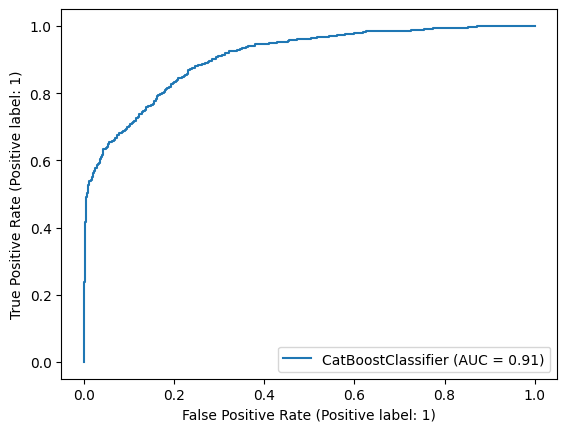

In [27]:
from sklearn.metrics import RocCurveDisplay
cb_best.fit(X_train, y_train)
RocCurveDisplay.from_estimator(
   cb_best, X_test, y_test)


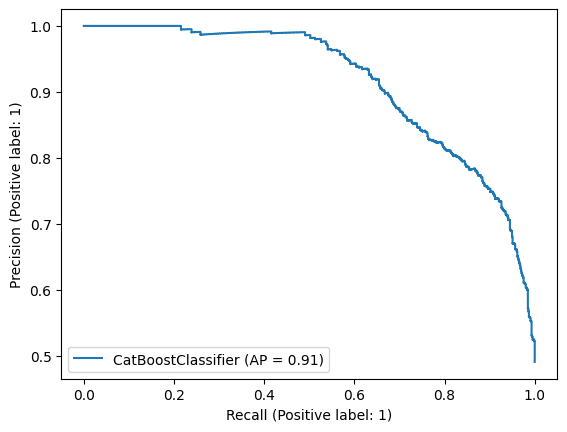

In [28]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(
   cb_best, X_test, y_test)

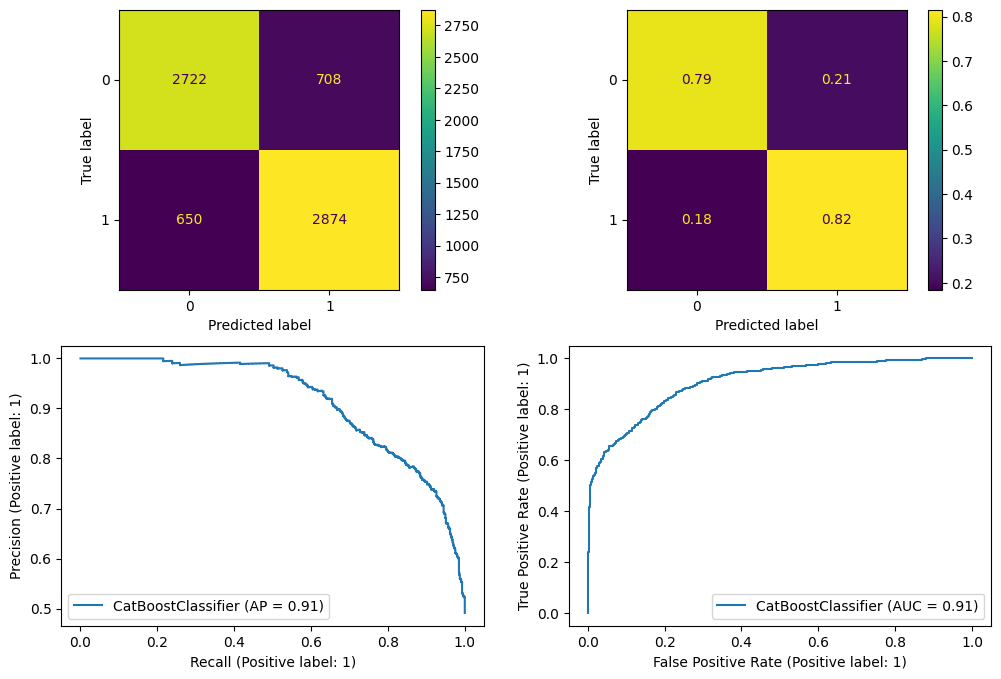

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
RocCurveDisplay.from_estimator(
   cb_best, X_test, y_test, ax=ax[1, 1])


PrecisionRecallDisplay.from_estimator(
   cb_best, X_test, y_test, ax=ax[1, 0])

ConfusionMatrixDisplay.from_predictions(y_train, y_pred, ax=ax[0, 0])
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, normalize="true", ax=ax[0, 1])
plt.show()

In [30]:
%%time

# always use same RANDOM_STATE k-folds for comparability between tests, reproducibility
RANDOMSTATE = 42
np.random.seed(RANDOMSTATE)

kfolds = KFold(n_splits=20, shuffle=True, random_state=RANDOMSTATE)

MEAN_RESPONSE=y_train.mean()
def cv_to_raw(cv_val, mean_response=MEAN_RESPONSE):
    return np.expm1(mean_response+cv_val) - np.expm1(mean_response)
	
scores = -cross_val_score(cb_best, X_train, y_train,
                          scoring="neg_root_mean_squared_error",
                          cv=kfolds,
                          n_jobs=-1)
raw_scores = [cv_to_raw(x) for x in scores]
print("Raw CV RMSE %.0f (STD %.0f)" % (np.mean(raw_scores), np.std(raw_scores)))

0:	learn: 0.6358546	total: 59.8ms	remaining: 5.92s
0:	learn: 0.6302891	total: 60.1ms	remaining: 5.95s
0:	learn: 0.6308428	total: 61.5ms	remaining: 6.09s
1:	learn: 0.5935760	total: 68.3ms	remaining: 3.35s
1:	learn: 0.5974334	total: 68.7ms	remaining: 3.37s
2:	learn: 0.5633183	total: 74.3ms	remaining: 2.4s
1:	learn: 0.5941755	total: 69.9ms	remaining: 3.43s
2:	learn: 0.5598159	total: 76.1ms	remaining: 2.46s
3:	learn: 0.5392374	total: 81.1ms	remaining: 1.95s
3:	learn: 0.5373707	total: 82.8ms	remaining: 1.99s
2:	learn: 0.5612135	total: 80.2ms	remaining: 2.59s
4:	learn: 0.5190440	total: 88.6ms	remaining: 1.68s
3:	learn: 0.5394951	total: 86.2ms	remaining: 2.07s
4:	learn: 0.5174291	total: 91.4ms	remaining: 1.74s
5:	learn: 0.5027429	total: 98.7ms	remaining: 1.54s
5:	learn: 0.5000048	total: 99.5ms	remaining: 1.56s
4:	learn: 0.5214579	total: 94.7ms	remaining: 1.8s
6:	learn: 0.4879646	total: 107ms	remaining: 1.42s
5:	learn: 0.5041105	total: 102ms	remaining: 1.6s
6:	learn: 0.4913489	total: 108ms	rem

In [31]:
max_scores = sum(score for score, name in zip(cb_best.feature_importances_, X_train.columns))

for score, name in zip(cb_best.feature_importances_, X_train.columns):
    print(f"{score/max_scores * 100:.1f}%{' ':>20}{name.split('__', 1)[1]:>20}")

3.4%                                     Age
9.3%                             RoomService
5.8%                               FoodCourt
3.1%                            ShoppingMall
11.1%                                     Spa
10.2%                                  VRDeck
8.7%                             CabinNumber
3.9%                                   Total
11.6%                              HomePlanet
6.6%                               CryoSleep
2.0%                             Destination
0.0%                                     VIP
4.2%                                   Group
0.4%                                Group_id
2.2%                                 Surname
12.6%                                    Deck
5.0%                               CabinSide


0:	learn: 0.6597978	total: 2.35ms	remaining: 233ms
1:	learn: 0.6277493	total: 3.88ms	remaining: 190ms
2:	learn: 0.5877056	total: 6.14ms	remaining: 199ms
3:	learn: 0.5680464	total: 7.77ms	remaining: 187ms
4:	learn: 0.5347265	total: 9.26ms	remaining: 176ms
5:	learn: 0.5189950	total: 10.8ms	remaining: 169ms
6:	learn: 0.5057417	total: 12.1ms	remaining: 160ms
7:	learn: 0.4967493	total: 13.6ms	remaining: 156ms
8:	learn: 0.4811954	total: 14.8ms	remaining: 149ms
9:	learn: 0.4695130	total: 16.1ms	remaining: 145ms
10:	learn: 0.4570890	total: 17.2ms	remaining: 140ms
11:	learn: 0.4446693	total: 18.3ms	remaining: 134ms
12:	learn: 0.4352081	total: 20ms	remaining: 134ms
13:	learn: 0.4266466	total: 21.1ms	remaining: 130ms
14:	learn: 0.4172085	total: 22.1ms	remaining: 125ms
15:	learn: 0.4073700	total: 23.4ms	remaining: 123ms
16:	learn: 0.4000734	total: 24.5ms	remaining: 120ms
17:	learn: 0.3930993	total: 25.7ms	remaining: 117ms
18:	learn: 0.3867349	total: 26.8ms	remaining: 114ms
19:	learn: 0.3764749	tot

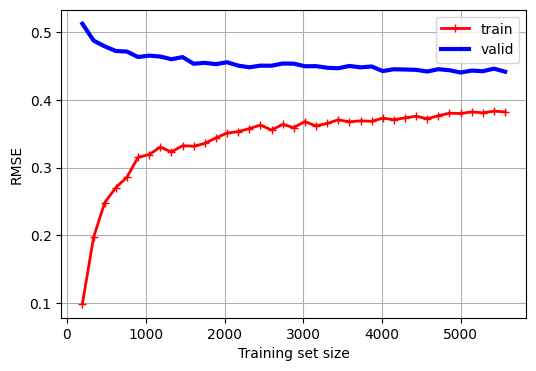

In [32]:
train_sizes, train_scores, valid_scores = learning_curve(
    cb_best, X_train, y_train, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code – beautifies and saves Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
# plt.axis([0, 1000, 0.3, 0.9])
# plt.save_fig("underfitting_learning_curves_plot")

plt.show()

In [33]:
#----------------For submission----------------
data1= pd.read_csv("data_FAA/train.csv")
data2 = pd.read_csv("data_FAA/evaluation.csv")
data2 = pd.read_csv("data_FAA/evaluation.csv")
data2['Transported'] =-1

data1, y1 = pandas_preprocessing(data1)
data2, y2 = pandas_preprocessing(data2)

data1 = preprocessing_pipe.fit_transform(data1)
data2 = preprocessing_pipe.transform(data2)

cb_best.fit(data1, y1)

pred = cb_best.predict(data2)

pred = pred.astype(bool)
result=pd.read_csv('data_FAA/sample_submission.csv')
result['Transported'] = pred
result.to_csv('submissions/submission_cat_nobins.csv', index=False)

0:	learn: 0.6289525	total: 1.89ms	remaining: 187ms
1:	learn: 0.5879933	total: 3.85ms	remaining: 189ms
2:	learn: 0.5562393	total: 5.64ms	remaining: 182ms
3:	learn: 0.5322423	total: 7.54ms	remaining: 181ms
4:	learn: 0.5135182	total: 9.38ms	remaining: 178ms
5:	learn: 0.4973468	total: 11.1ms	remaining: 174ms
6:	learn: 0.4851705	total: 12.7ms	remaining: 169ms
7:	learn: 0.4761455	total: 14.4ms	remaining: 165ms
8:	learn: 0.4675596	total: 16.1ms	remaining: 163ms
9:	learn: 0.4606986	total: 17.8ms	remaining: 160ms
10:	learn: 0.4517031	total: 19.5ms	remaining: 157ms
11:	learn: 0.4473746	total: 21ms	remaining: 154ms
12:	learn: 0.4419833	total: 22.7ms	remaining: 152ms
13:	learn: 0.4384299	total: 24.4ms	remaining: 150ms
14:	learn: 0.4353665	total: 26ms	remaining: 147ms
15:	learn: 0.4329262	total: 27.6ms	remaining: 145ms
16:	learn: 0.4308398	total: 29.3ms	remaining: 143ms
17:	learn: 0.4283728	total: 31.1ms	remaining: 142ms
18:	learn: 0.4258891	total: 32.7ms	remaining: 139ms
19:	learn: 0.4220838	total